# Modeling the experiments of Cone *et al.* (PNAS 2016) according to HRL

This report introduces an attempt to model the experiments of Cone *et al.* (2016), which suggest that dopamine RPE signals are gated by physiological states. These experiments involved rats, which dopamine responses to sodium cues were recorded for different degrees of sodium depletion. In the following work, Cone *et al.*'s results are replicated according to Homeostatic Reinforcement Learning (HRL) theory, as developed in Keramati & Gutkin's research (Keramati & Gutkin, 2011; Keramati & Gutkin, 2014).  


## 1. Experiment 1: Uncued intraoral infusions and overnight sodium intake

Experiment 1 involved several groups of rats: Replete ($n=4$), Deplete ($n=5$), Re-Replete ($n=4$), Deplete+Amiloride ($n=5$). Rats in the Replete condition were tested in a positive state of sodium balance, whereas Deplete rats were depleted of sodium for 24h before the dopamine recording session. Rats in the Re-Replete condition were sodium-depleted, but allowed to restore sodium balance for 48h before testing. Finally, Deplete+Amiloride rats were sodium-depleted, but received sodium in amiloride during the test. Indeed, amiloride interferes with sodium taste perception, which allowed the experimenters to study the influence of orosensory properties on sodium intake and dopamine response. 
The session consisted in 10 intraoral infusions of 200 μL NaCl, that were delivered by a solenoid valve over 4 s. During the whole session, rats' phasic dopamine responses were recorded using FSCV. Then, rats were returned to their home cage and given *ad libitum* access to an NaCl solution during the night. Their sodium intake, in mL, was measured in order to test their sodium appetite (cf. Cone *et al.* 2016, Supplementary, p. 1).   


### 1. 1. HRL model of Uncued intraoral infusions

In this replication, only Replete, Deplete, and Deplete+Amiloride conditions were taken into account. Like in the experiment, the trial schedule consisted in 10 intraoral infusion trials, that were separated by variable intertrial intervals (60 $\pm$ 8.2 s) to prevent anticipation. To deliver 200 μL over 4 s, it was assumed that, during a trial, 5 μL were delivered per 0.1 s. This resulted in the trial schedule below:  


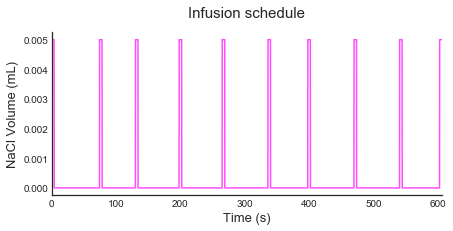

In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

#create trial schedule
mu, sigma = 600, 82 #mean and SD (1/10 s)
intervals = np.random.normal(mu, sigma, 9)

for i in range(len(intervals)):
    intervals[i]=int(intervals[i])
    
total_time=int(sum(intervals)+400) #total length of the session

K_t=np.zeros((total_time)) #stores the amount of infused sodium

k=0
for i in range((len(intervals))):
    for j in range(40):
        K_t[k]=0.005 #mL
        k=k+1
    k=k+int(intervals[i])
for i in range(40):
    K_t[k]=0.005 #mL
    k=k+1
    
time=np.arange(0, total_time/10, 0.1)

#plot trial schedule
plt.figure(figsize=(7, 3))
ax=plt.subplot(111)
ax.plot(time, K_t, 'magenta', alpha=0.7)
ax.set_ylabel('NaCl Volume (mL)', fontsize=13)
ax.set_xlabel('Time (s)', fontsize=13)
ax.set_xlim(0, total_time/10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Infusion schedule', fontsize=15, pad=15)
plt.show()

In order to model the rats' responses according to HRL, several variables needed to be defined--such as the sodium setpoint $H^{*}$, the drive $d$, and the orosensory estimate $\hat K$. 

Since it was impossible, given the available information, to know what a "normal sodium balance" would amount to, the sodium setpoint was arbitrarily set at $H^{*} = 25$ for all rats, and the initial internal states were:

* $H_0 = H^{*} = 25$ in the Replete condition;
* $H_0 = 2$ in the Deplete and Deplete+Amiloride conditions.

During one trial, 200 μL of sodium were delivered for 4 s. Following HRL, the delivery of sodium acquires a rewarding value $r$ by reducing the animal's drive $d$, which is computed with respect to the sodium setpoint $H^{*}$ (cf. Keramati & Gutkin 2011, p. 84). Here, the chosen expression of $d$ was:

$$ d(H_{t}) = \lvert H^{*} - H_{t} \rvert^{2} $$

$H_{t}$ being the animal's internal state at time $t$. 

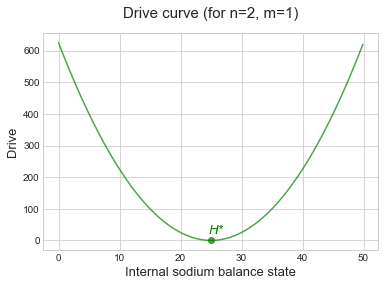

In [2]:
plt.style.use('seaborn-whitegrid')

H_star=25 #setpoint

#Drive function
def drive(h, h_s, n, m):
    dr=(np.absolute(h_s - h))**(n/m)
    return dr

#plot drive function
values=np.arange(0, 50, 0.1)
drives=np.zeros((len(values)))
for i in range(len(values)):
    drives[i]=drive(values[i], H_star, 2, 1)
    
plt.figure()
plt.plot(values, drives, 'g-', alpha=0.7)
plt.plot(H_star, 0, 'go', alpha=0.7)
plt.annotate('H*', (H_star, 0), (24.5, 20), fontsize=13, style='italic', color='green')
plt.ylabel('Drive', fontsize=13)
plt.xlabel('Internal sodium balance state', fontsize=13)
plt.title("Drive curve (for n=2, m=1)", fontsize=15, pad=15)
plt.show()

According to HRL, the rewarding value of sodium delivery at time $t$ is:

$$ r(t) = d(H_{t-1})-d(H_{t-1}+ \hat K_{t}) $$

$\hat K_{t}$ being the animal's orosensory estimate of the amount of sodium that is delivered at time $t$. Although $\hat K_{t}$ is used in the computation of the reward, the internal state updates with respect to the real amount of sodium that is delivered at time $t$, $K_{t}$. Thus, $H_{t} = H_{t-1} + K_{t}$. Since amiloride blocks sodium taste, it was hypothesized that Deplete+Amiloride rats had no estimate of the amount of sodium they consumed, whereas Deplete and Replete rats were assumed to have a perfect estimate of their consumption. Thus, in the model:

* for Deplete and Replete rats, $\hat K_{t} = K_{t}$ for all $t$;
* for Deplete+Amiloride rats, $\hat K_{t} = 0$ for all $t$. 

As one can predict, this will have an influence on the way the reward is computed for the different groups of rats. 


### 1. 2. Results

During the FSCV recording session, it appeared that only Deplete rats responded to sodium delivery in a significant fashion, with a phasic dopamine release. From this, Cone *et al.* concluded that the dopamine response to intraoral NaCl is taste-dependent, and depends on physiological state at the time of NaCl exposure (Cone *et al.* 2016, p. 2).

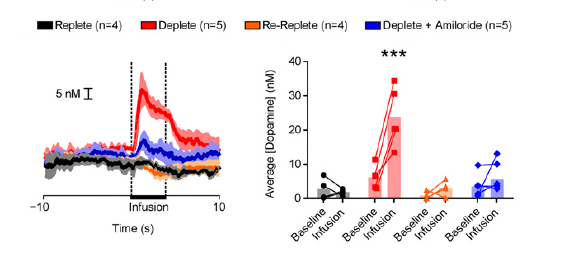

**Fig. 1 -** *Only Deplete rats respond significantly to sodium delivery during uncued intraoral infusion session. The first picture shows average dopamine concentration ($\pm$ SEM) evoked by intraoral NaCl across groups.* From Cone *et al.* 2016, p. 2.

In this replication, it was assumed that dopamine responses could be matched with the rewarding value $r$: a positive dopamine response corresponds to a positive rewarding value. From this perspective, the HRL model seems to replicate the experimental results quite well: by computing and plotting the rewarding value $r$ of the infusions, one can show that Deplete rats' responses are positive and high, whereas Deplete+Amiloride rats' responses are null during the whole sessions. Replete rats exhibit negative responses, but these are small and can be neglected. 

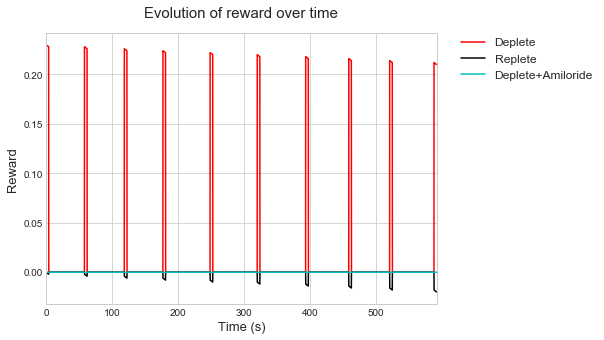

In [3]:
#define internal estimates
K_hat=np.zeros((total_time)) #Deplete and Replete rats
K_hat_amiloride=np.zeros((total_time)) #Deplete+Amiloride rats

for i in range(total_time):
    K_hat[i]=K_t[i]
    

#define the way internal states, rewards and drives are updated during the whole session
def update_infusion(t, k_h, k, h0, h_s, n, m):
    h=np.zeros((len(t))) #stores the internal states
    r=np.zeros((len(t))) #stores the rewards
    d=np.zeros((len(t))) #stores the drives
    h[0]=h0
    d[0]=drive(h[0], h_s, n, m)
    for i in range(1, len(t)):
        h[i]=h[i-1]+k[i] #update internal state
        d[i]=drive(h[i], h_s, n, m) #compute drive
        r[i]=drive(h[i-1], h_s, n, m)-drive(h[i-1]+k_h[i], h_s, n, m) #compute reward according to HRL
    return d, h, r


#generate infusion sessions for Replete, Deplete, and Deplete+Amiloride
sequence=update_infusion(time, K_hat, K_t, 2, H_star, 2, 1) #Deplete
sequence2=update_infusion(time, K_hat, K_t, 25, H_star, 2, 1) #Replete
sequence3=update_infusion(time, K_hat_amiloride, K_t, 2, H_star, 2, 1) #Deplete+Amiloride

D1=sequence[0] #Deplete
H1=sequence[1]
R1=sequence[2]

D2=sequence2[0] #Replete
H2=sequence2[1]
R2=sequence2[2]

D3=sequence3[0] #Deplete+Amiloride
H3=sequence3[1]
R3=sequence3[2]

#plot evolution of reward over time
plt.figure(figsize=(7, 5))
ax=plt.subplot(111)
ax.plot(time, R1, 'r-', label='Deplete')
ax.plot(time, R2, 'k-', label='Replete')
ax.plot(time, R3, 'c-', label='Deplete+Amiloride')
ax.set_ylabel('Reward', fontsize=13)
ax.set_xlabel('Time (s)', fontsize=13)
ax.set_xlim(0, total_time/10)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
ax.set_title('Evolution of reward over time', fontsize=15, pad=15)
plt.show()



If Replete rats exhibit small negative responses, it is because the intraoral infusions make them depart slightly from their sodium setpoint. The quadratic form of the drive function ensures that this deviation remains small--at least, much smaller  than the reduction of drive in Deplete rats, despite their equal sodium consumptions. Deviation from setpoint in Replete and Deplete rats during Experiment 1 can be seen on the plot below:

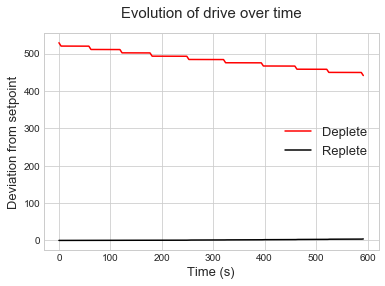

In [4]:
#plot evolution of drive over time
plt.figure()
plt.plot(time, D1, 'r-', label='Deplete')
plt.plot(time, D2, 'k-', label='Replete')
plt.ylabel('Deviation from setpoint', fontsize=13)
plt.xlabel('Time (s)', fontsize=13)
plt.legend(fontsize=13)
plt.title('Evolution of drive over time', fontsize=15, pad=15)
plt.show()

### 1.3. HRL model of Overnight sodium intake

After the infusion session, Cone *et al.* probed the rats' sodium appetite by giving them *ad libitum* sodium access during the night. At the end of the test, each rat's total sodium intake was measured (in mL). To model the overnight session, a softmax policy was used. For twelve hours, the model rat can choose to drink sodium every minute. Its default state, $s_0$, is the "rest" state--while $s_1$ leads the rat to drink 0.2 mL of an NaCl solution if such an action is chosen. At the beginning, the probability for the rats to take action $a$ in order to be in state $s_1$ is 0.5 (exploratory behavior). Then, this probability updates with respect to the rewarding value of sodium intake: if $r$ is strictly positive, the quality $q$ of taking action $a$ when in state $s_0$ equals 1; if $r$ is null or negative, $q(s_0, a) = 0$. The probability $p$ of choosing action $a$ in state $s_0$ updates according to the following rule:

$$ p(a \vert s_0) \rightarrow p(a \vert s_0) + \epsilon * [q(s_0, a) - p(a \vert s_0)] $$

where $\epsilon$ is the learning rate. The reward $r$ that is delivered in state $s_1$ is computed according to the HRL model--that is, as a function of drive. Moreover, it is assumed again that Deplete and Replete rats have a perfect estimate $\hat K_{t}$ of the NaCl volume $K_{t}$ that they drink at time $t$, whereas for Deplete+Amiloride rats, $\hat K_{t} = 0$ for all $t$. Therefore, this experiment helps delineate the role of orosensory estimates in sodium-seeking behavior. 

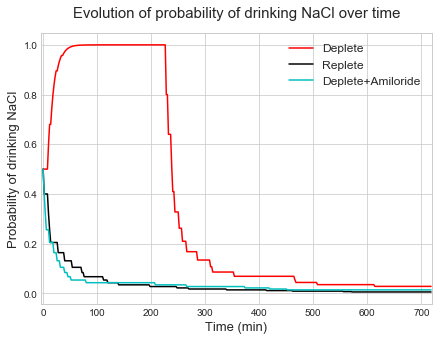

In [5]:
overnight=np.arange(0, 720, 2)

def update_softmax(t, beta, k_h, k, h0, p0, h_s, eps, gamma, n, m): 
    h=np.zeros((len(t))) #stores the internal states
    r=np.zeros((len(t))) #stores the rewards
    d=np.zeros((len(t))) #stores the drives
    v=np.zeros((len(t))) #stores the predictions
    p=np.zeros((len(t))) #stores probabilities of taking action a
    choice=np.zeros((len(t))) #stores the choices
    total_intake=0 #total intake of sodium (mL)
    h[0]=h0 #initial internal state
    p[0]=p0 #initial probability of taking action a
    d[0]=drive(h[0], h_s, n, m) #initial drive
    for i in range(1, len(t)):
        c=np.random.random()
        if c<=p[i-1]: #if c<=p, the rat takes action a
            choice[i]=1
            h[i]=h[i-1]+k #k=amount of sodium that the rat drinks
            r[i]=drive(h[i-1], h_s, n, m)-drive(h[i-1]+k_h, h_s, n, m) #compute reward according to HRL
            total_intake=total_intake+k
            if r[i]>0:
                q=1
            else:
                q=0
        else:
            choice[i]=0 #if c>p, the rat stays in state s_0
            h[i]=h[i-1] #internal state doesn't update
            q=p[i-1] #so that p does not update (the rat doesn't learn anything)
        d[i]=drive(h[i], h_s, n, m)
        p[i]=p[i-1]+eps*(q-p[i-1]) #update rule for p
    return choice, v, d, p, total_intake, h, r


#Run the algorithm for Replete, Deplete and Deplete+Amiloride rats

intake_test=update_softmax(overnight, 15, 0.2, 0.2, H1[-1], 0.5, H_star, 0.2, 0.9, 2, 1) #Deplete rats
p_deplete=intake_test[3]

intake_test2=update_softmax(overnight, 15, 0.2, 0.2, H2[-1], 0.5, H_star, 0.2, 0.9, 2, 1) #Replete rats
p_replete=intake_test2[3]

intake_test3=update_softmax(overnight, 15, 0, 0.2, H3[-1], 0.5, H_star, 0.2, 0.9, 2, 1) #Deplete+Amiloride rats
p_deplete_amiloride=intake_test3[3]

#plot probability of NaCl drinking during overnight test
plt.figure(figsize=(7, 5))
ax=plt.subplot(111)
ax.plot(overnight, p_deplete, 'r-', label='Deplete')
ax.plot(overnight, p_replete, 'k-', label='Replete')
ax.plot(overnight, p_deplete_amiloride, 'c-', label='Deplete+Amiloride')
ax.set_ylabel('Probability of drinking NaCl', fontsize=13)
ax.set_xlabel('Time (min)', fontsize=13)
ax.set_xlim(-4, overnight[-1]+1)
ax.legend(fontsize=12)
ax.set_title('Evolution of probability of drinking NaCl over time', fontsize=15, pad=15)
plt.show()

### 1. 4. Results

After the overnight test, Cone *et al.* found out that Deplete rats had consumed significantly more sodium than Replete and Deplete+Amiloride rats. Interestingly, Deplete+Amiloride rats had not consumed more sodium than Replete rats, despite their sodium deficiency. Cone *et al.* thus concluded that "100 μM amiloride is sufficient to disrupt the ability of sodium-depleted rats to identify and exploit sources of sodium" (Cone *et al.* 2016, Supplementary, p. 3). Each group's average overnight sodium intake can be read on the graph below:

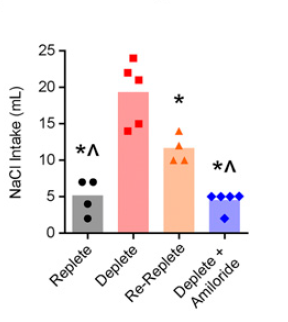

**Fig. 2 -** *Overnight NaCl intake across all groups of rats.* From Cone *et al.* 2016, p. 2.

As shown on the following plot, the HRL model replicates these results quite well:

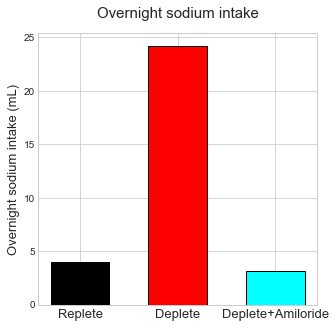

In [6]:
intake_deplete=intake_test[4] #total intake of Deplete rats
intake_replete=intake_test2[4] #total intake of Replete rats
intake_deplete_amiloride=intake_test3[4] #total intake of Deplete+Amiloride rats

#plot total intake for all conditions
barWidth = 0.3
Bars=[intake_replete, intake_deplete, intake_deplete_amiloride]
r1 = np.arange(0, len(Bars)/2, 0.5)
plt.figure(figsize=(5, 5))
plt.bar(r1, Bars, width = barWidth, color = ['black', 'red', 'cyan'], edgecolor = 'black', capsize=7)
plt.xticks([r/2 for r in range(len(Bars))], ['Replete', 'Deplete', 'Deplete+Amiloride'], fontsize=13)
plt.ylabel('Overnight sodium intake (mL)', fontsize=13) 
plt.title('Overnight sodium intake', fontsize=15, pad=15)
plt.show()

Therefore, it seems that HRL theory constitutes an accurate framework to explain the dependency of sodium's rewarding value on physiological state, as well as the role of orosensory estimates in sodium-seeking behavior in rats. In the following sections, what is investigated is the ability of HRL theory to predict Cone and colleagues' results in conditioning experiments. 



## 2. Experiment 2: Response to outcome-predictive stimuli, training in a Replete condition 

In Experiment 2, Cone *et al.* trained 10 sodium-replete rats over 7 days in total. Training consisted in the following: during each trial, a conditioned stimulus (CS) preceded an unconditioned stimulus (US), which was a 200 μL intraoral infusion of NaCl. The CS was a light cue, which lasted 10 s, and was coupled with the extension of a lever. 6 s after the CS onset, the NaCl solution was delivered for 4 s. Each training session consisted of 30 trials. After 7 training days, one subset of rats ($n=5$, Deplete) was depleted of sodium, while the others ($n=5$, Replete) were allowed to maintain a normal sodium balance. Then, both subsets were trained in extinction for 20 trials, in order to see whether the CS alone could trigger a phasic dopamine response. After the extinction session, a reinstatement session took place (20 trials), where the CS was coupled with the US again. Dopamine responses to the CS and/or the US were looked for, in both subsets of rats.


### 2. 1. HRL model of Experiment 2

To model Experiment 2, a TD-learning algorithm was used. However, the CS did not last 10 s: the signal raised to 1 only at the time of the CS onset. The reward was delivered 6 s later, for 4 s (50 μL/s, 200 μL in total). The intertrial interval was set at 30 s. This setting is shown on the plot below:

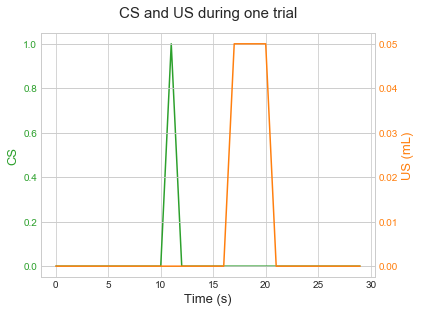

In [7]:
#create trial schedule
l=40 #length of a trial (s)
n_total=70*l #length of the whole experiment (s)

CS=np.zeros((l))
US=np.zeros((l)) #US during training and reinstatement
US_ext=np.zeros((l)) #US during extinction

CS[11]=1 #CS raises to 1 for 1 s
for j in range(17, 21):
    US[j]=0.05 #US is delivered for 4 s, 6 s later

time=np.arange(0, n_total, 1)

#plot trial schedule
plt.figure(figsize=(6, 4.5))
ax1 = plt.subplot(111)
color = 'tab:green'
ax1.set_xlabel('Time (s)', fontsize=13)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax1.plot(time[:30], CS[:30], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('CS and US during one trial', fontsize=15, pad=15)
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('US (mL)', color=color, fontsize=13)  
ax2.plot(time[:30], US[:30], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

To make the modeling simpler, the TD algorithm was run on a single training session (30 trials). Then, it was run on an extinction session (20 trials), and on a reinstatement session (20 trials), like in the experiment. During the extinction session, only the CS was present. According to TD-learning, the prediction error $\delta$ updates in the following way:

$$ \delta(t) = r(t) + v(t+1) - v(t) $$

where $r(t)$ is the reward at time $t$, and $v(t+1) - v(t)$ is the temporal difference between the animal's prediction at time $t$ and the prediction at time $t+1$. Predictions $v$, in turn, are computed according to the following equation:

$$ v(t) = \sum_{\tau=0}^{t} w(\tau)u(t - \tau) $$

where $u(t - \tau)$ is the value of the CS at time $t - \tau$ (0 if absent, 1 if present). Finally, the weights $w$ are updated according to a generalized Rescorla-Wagner rule:

$$ w(\tau) \rightarrow w(\tau) + \epsilon \delta(t) u(t-\tau) $$

Specific to the HRL model, the rewards $r$ were updated according to HRL theory (see Section 1. 1.). Once again, the setpoint $H^{*}$ was set at 25, and the learning rate $\epsilon$ at 0.1. The internal states of Replete rats were reset at 25 at the beginning of each session, while Deplete rats' internal states were set at 2 at the beginning of the extinction session. 


### 2. 2. Results

During the first FSCV recording session, while rats were tested in extinction, Cone *et al.* did not find any phasic dopamine response in reaction to the CS in either groups. During the reinstatement session, however, the Deplete subset responded to the US. These results are shown on the figure below. Thus, Cone *et al.* concluded that the acquisition of dopamine reward predictions requires that the predicted outcome first be experienced as appetitive (Cone *et al.* 2016, p. 2). 

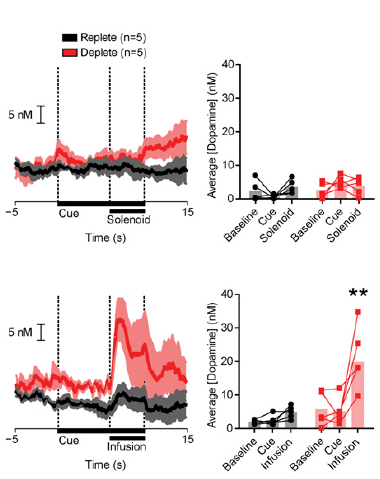

**Fig. 3 -** *First row: Average dopamine in both groups during extinction. Second row: Average dopamine in both groups during reinstatement.* From Cone *et al.* 2016, p. 3.

As it is shown below, HRL theory predicts these results rather well:

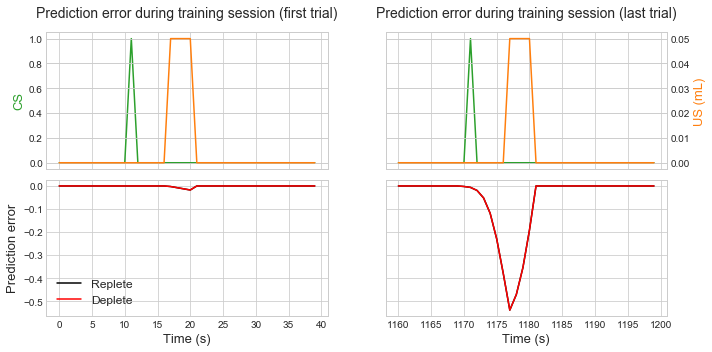

In [8]:
#reset internal states at the beginning of each session
H_R=np.zeros((n_total)) #Replete
H_D=np.zeros((n_total)) #Deplete

H_R[30*l]=25 #reset Replete rats' internal states at 25 at the beginning of each new session
H_R[50*l]=25

H_D[30*l]=2 #reset Deplete rats' internal states at 2 at the beginning of the extinction session

#initial weights
w1R=np.zeros((l)) 
w1D=np.zeros((l)) 

#Learning rate
Epsilon=0.1

delivery=np.zeros((n_total)) #indicates that there is no US during the extinction session
for i in range(30*l+1, 50*l+1):
    delivery[i]=1
    
#Temporal-Difference learning algorithm
def update_TD(N, length, u, h0, h_init, eps, h_s, n, m, w):
    h=np.zeros((N)) #stores the internal states
    h[0]=h0 #initial internal state
    r=np.zeros((N)) #stores the rewards
    d=np.zeros((N)) #stores the drives
    v=np.zeros((N)) #stores the predictions
    delta=np.zeros((N)) #stores the prediction errors
    delta_v=np.zeros((N)) #stores the temporal difference
    d[0]=drive(h[0], h_s, 2, 1) #initial drive
    for t in range(1, N):
        c=t%length
        if delivery[t]==0:
            k=US #training and reinstatement sessions
        else:
            k=US_ext #extinction session
        u_t=u[:c+1]
        w_t=w[:c+1]
        v[t]=np.dot(w_t, u_t[::-1])
        delta_v[t-1]=v[t]-v[t-1] #temporal difference
        delta[t-1]=r[t-1]+delta_v[t-1] #TD rule
        h[t]=h[t-1]+k[c]#update internal state
        d[t]=drive(h[t], h_s, n, m) #compute drive
        r[t]=drive(h[t-1], h_s, n, m)-drive(h[t], h_s, n, m) #compute reward according to HRL
        if h_init[t]>0: #reset internal state at the beginning of a new session
            h[t]=h_init[t]
        for tau in range(c):
            w[tau]=w[tau]+eps*delta[t-1]*u[c-1-tau] #update weights according to generalized RW rule
    return v, w, delta, r, h, d, delta_v


#Run the algorithm for Replete and Deplete rats
session=update_TD(n_total, l, CS, 25, H_R, Epsilon, H_star, 2, 1, w1R) #Replete rats
session2=update_TD(n_total, l, CS, 25, H_D, Epsilon, H_star, 2, 1, w1D) #Deplete rats

#Replete
V11=session[0]
W11=session[1]
Delta11=session[2]
R11=session[3]
H11=session[4]
D11=session[5]

#Deplete
V12=session2[0]
W12=session2[1]
Delta12=session2[2]
R12=session2[3]
H12=session2[4]
D12=session2[5]


#Plot Prediction errors

#training
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[0:40], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[0:40], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[1160:1200], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[1160:1200], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[0:40], Delta11[0:40], 'k-', label='Replete')
ax3.plot(time[0:40], Delta12[0:40], 'r-', label='Deplete')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[1160:1200], Delta11[1160:1200], 'k-')
ax4.plot(time[1160:1200], Delta12[1160:1200], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during training session (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during training session (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

During the training session, both groups are sodium-replete. This is why both groups have the same prediction errors over the whole session. One can notice that, over the last trial, the prediction error has become quite big and negative at the time of sodium delivery. This is because rats were replete since the beginning; after 30 intraoral infusions, their setpoint $H^{*}$ is quite overshot and, thus, according to HRL theory, sodium drinking becomes punishing. 

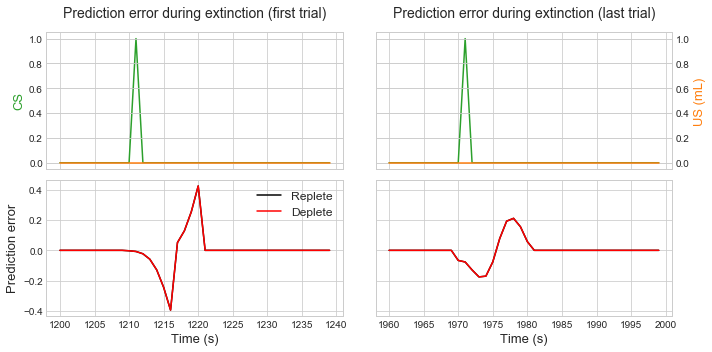

In [9]:
#extinction
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[1200:1240], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[1200:1240], US_ext, color=color)
ax11.tick_params(axis='y', labelcolor='white')
ax11.set_ylim(ax1.get_ylim())
color = 'tab:green'
ax2.plot(time[1960:2000], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[1960:2000], US_ext, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.set_ylim(ax1.get_ylim())
ax21.tick_params(axis='y')
ax3.plot(time[1200:1240], Delta11[1200:1240], 'k-', label='Replete')
ax3.plot(time[1200:1240], Delta12[1200:1240], 'r-', label='Deplete')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[1960:2000], Delta11[1960:2000], 'k-')
ax4.plot(time[1960:2000], Delta12[1960:2000], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during extinction (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during extinction (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

At the beginning of the extinction session, the animals are not in the same condition anymore. Replete rats ($n=5$) have an internal state of 25, while Deplete rats' internal state is set at 2. However, the plot above shows that their prediction errors remain identical. In the absence of the US, indeed, Deplete and Replete rats' predictions update the same way because there is no sodium to change the drive and thus make a difference to the variable $r$. In the plot above, the somewhat sinusoidal shape of the prediction error is due to what the rats have learnt before: the CS has been associated with punishment (since, during the training session, sodium-drinking was punishing), but, as nothing happens (no US), the setpoint $H^{*}$ is not overshot like before, contrary to the rats' expectations. This pattern persists until the end of the extinction session, although it attenuates gradually. Interestingly, this does not seem to appear in the experimental results. This is most probably because, in Cone *et al.*'s experiments, sodium drinking does not acquire such a negative value at the end of the training session. In the HRL framework, this issue could be fixed by choosing more appropriate parameters $n$ and $m$ for the drive function; for $n=4$ and $m=3$, for instance, the sinusoidal pattern would persist, but its amplitude would be smaller.   

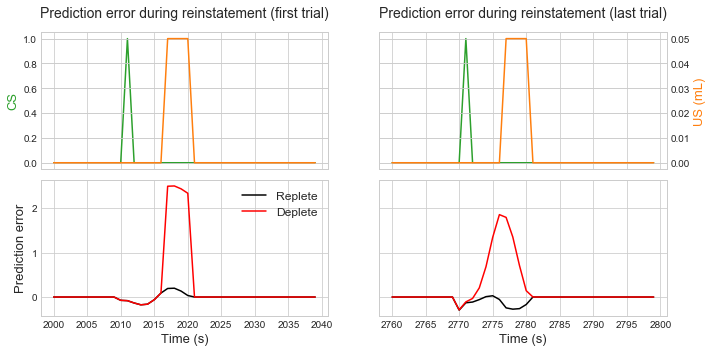

In [10]:
#reinstatement
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[2000:2040], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[2000:2040], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[2760:2800], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[2760:2800], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[2000:2040], Delta11[2000:2040], 'k-', label='Replete')
ax3.plot(time[2000:2040], Delta12[2000:2040], 'r-', label='Deplete')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[2760:2800], Delta11[2760:2800], 'k-')
ax4.plot(time[2760:2800], Delta12[2760:2800], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during reinstatement (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during reinstatement (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

Finally, the computational results match the experimental results quite well concerning reinstatement. Indeed, Deplete rats exhibit a clear response to the US, but not to the CS, from the beginning until the end of the reinstatement session. Some fluctuations can be seen in the response of Replete rats, but they are very small and can be neglected. Thus, HRL theory seems to support the conclusion that, for rats to acquire dopamine reward predictions, the predicted outcome has to be first experienced as appetitive. 



## 3. Experiment 3: Effects of a single day of NaCl CS-US training while rats are sodium-deficient

In Experiment 3, Cone *et al.* investigated whether a single training session that pairs a CS with an appetitive US could bring about a dopamine reward prediction signal. To this purpose, they depleted 8 rats of sodium, and then split them in two groups: 

* Trained Deplete ($n=4$), which were depleted of sodium 24 h before training, and were trained during one single session while deplete;

* Trained Replete ($n=4$), which were depleted of sodium but then allowed to recover 48h before training, and were trained during one single session while replete. 

The training session consisted of 60 trials; in each trial, 100 μL of NaCl were delivered during 2 s before the CS offset. Afterwards, all rats were allowed to recover, and then depleted of sodium again. An FSCV recording session took place, where rats were tested over 20 trials to check for a phasic dopamine response to the CS and/or the US. 


### 3. 1. HRL model of Experiment 3

The model is very similar to that of Experiment 2, excepted for the fact that the trial schedule changed. The same TD-learning algorithm was used to update the prediction errors over time, and rewards were computed according to HRL theory. However, it was shown that a weaker $\epsilon$ was required in order to replicate the experimental results, at least qualitatively. In the following algorithm, $\epsilon$ was set at 0.01. This feature is discussed in Section 4. 


### 3. 2. Results

During the FSCV recording session, no phasic dopamine response was triggered in response to the CS in either group. However, the US brought about a phasic dopamine response in both groups. From this, Cone *et al.* concluded that a single training session that pairs a CS with an appetitive US is insufficient for the development of a dopamine reward prediction signal (Cone *et al.* 2016, p. 3). 

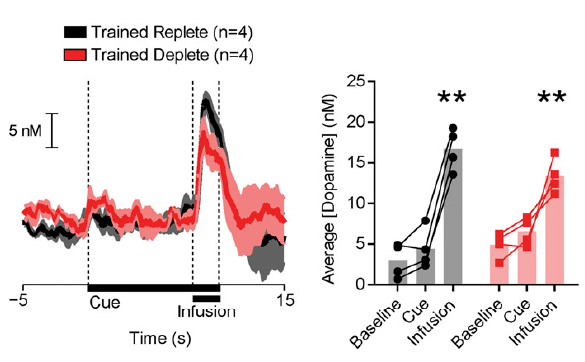

**Fig. 4 -** *Average dopamine concentration ($\pm$ SEM) across both groups.* From Cone *et al.* 2016, p. 3.


With $\epsilon = 0.01$, the HRL model replicates these results:

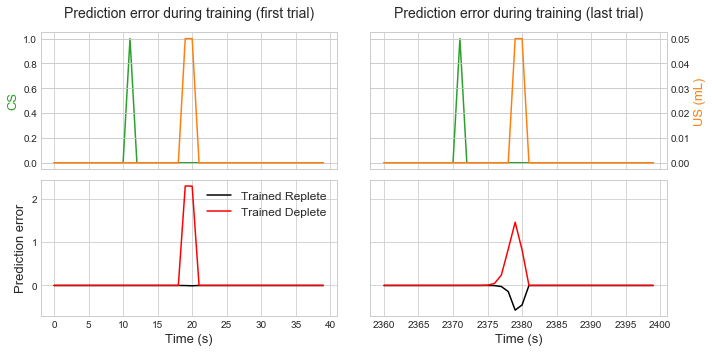

In [11]:
#create trial schedule
l=40 #length of a trial (s)
n_training=60*l #training session = 60 trials
n_test=20*l #FSCV recording session = 20 trials
n_total=n_training+n_test #length of the whole experiment

#generate CS and US
CS=np.zeros((l))
US=np.zeros((l))

CS[11]=1
for j in range(19, 21): #in this experiment NaCl is delivered during 2 s only
    US[j]=0.05
    
    
H_R=np.zeros((n_total))
H_D=np.zeros((n_total))

H_R[n_training]=2 #Trained Replete rats' internal states are reset at 2 before FSCV recording
H_D[n_training]=2 #Trained Deplete rats' internal states are reset at 2 before FSCV recording

#initial weights
w2R=np.zeros((l))
w2D=np.zeros((l))

#learning rate
Epsilon=0.01 

time=np.arange(0, n_total, 1)

#TD-learning algorithm for Experiment 3
def update_TD(N, length, u, k, h0, h_init, eps, h_s, n, m, w):
    h=np.zeros((N)) #stores the internal states
    h[0]=h0 #initial internal state
    r=np.zeros((N)) #stores the rewards
    d=np.zeros((N)) #stores the drives
    v=np.zeros((N)) #stores the predictions
    delta=np.zeros((N)) #stores the prediction errors
    delta_v=np.zeros((N)) #stores the temporal difference
    d[0]=drive(h[0], h_s, 2, 1) #initial drive
    for t in range(1, N):
        c=t%length
        u_t=u[:c+1]
        w_t=w[:c+1]
        v[t]=np.dot(w_t, u_t[::-1])
        delta_v[t-1]=v[t]-v[t-1] #temporal difference
        delta[t-1]=r[t-1]+delta_v[t-1] #TD rule
        h[t]=h[t-1]+k[c] #update internal state
        d[t]=drive(h[t], h_s, n, m) #compute drive
        r[t]=drive(h[t-1], h_s, n, m)-drive(h[t], h_s, n, m) #compute reward according to HRL
        if h_init[t]>0: #internal state is reset at the beginning of a new session
            h[t]=h_init[t]
        for tau in range(c):
            w[tau]=w[tau]+eps*delta[t-1]*u[c-1-tau] #update weights according to generalized RW rule
    return v, w, delta, r, h, d, delta_v


#Run the algorithm for Trained Deplete and Trained Replete conditions

trained_deplete=update_TD(n_total, l, CS, US, 2, H_D, Epsilon, H_star, 2, 1, w2D) #Trained Deplete rats
delta_deplete=trained_deplete[2]
h_deplete=trained_deplete[4]
delta_v_deplete=trained_deplete[6]
r_deplete=trained_deplete[3]
v_deplete=trained_deplete[0]
w_deplete=trained_deplete[1]

trained_replete=update_TD(n_total, l, CS, US, 25, H_R, Epsilon, H_star, 2, 1, w2R) #Trained Replete rats
delta_replete=trained_replete[2]
h_replete=trained_replete[4]
delta_v_replete=trained_replete[6]
r_replete=trained_replete[3]
v_replete=trained_replete[0]
w_replete=trained_replete[1]


#Plot prediction errors at different times

#training
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[:40], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[:40], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[2360:2400], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[2360:2400], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[:40], delta_replete[:40], 'k-', label='Trained Replete')
ax3.plot(time[:40], delta_deplete[:40], 'r-', label='Trained Deplete')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[2360:2400], delta_replete[2360:2400], 'k-')
ax4.plot(time[2360:2400], delta_deplete[2360:2400], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during training (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during training (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

As usual, the prediction error is high during sodium delivery in Deplete rats only. At the end of the training session, this prediction error has slightly decreased and moved to the left (towards the CS onset) as the rats gradually learn to associate the US with the CS. However, this response can still be considered as a response to the US only, as it is far from overlapping with the CS onset.  

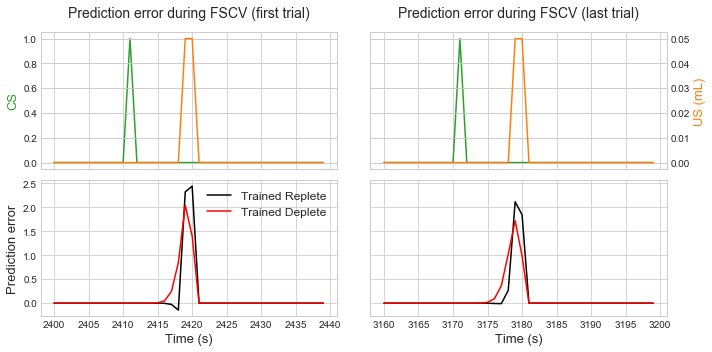

In [12]:
#FSCV recording session
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[2400:2440], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[2400:2440], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[3160:3200], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[3160:3200], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[2400:2440], delta_replete[2400:2440], 'k-', label='Trained Replete')
ax3.plot(time[2400:2440], delta_deplete[2400:2440], 'r-', label='Trained Deplete')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[3160:3200], delta_replete[3160:3200], 'k-')
ax4.plot(time[3160:3200], delta_deplete[3160:3200], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during FSCV (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during FSCV (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

From the beginning to the end of the FSCV recording session, both Trained Replete and Trained Deplete rats repond to the US only. This matches quite well with the experimental results. However, this could only be obtained with a low learning rate, $\epsilon = 0.01$. For $\epsilon = 0.1$, the results are the following:

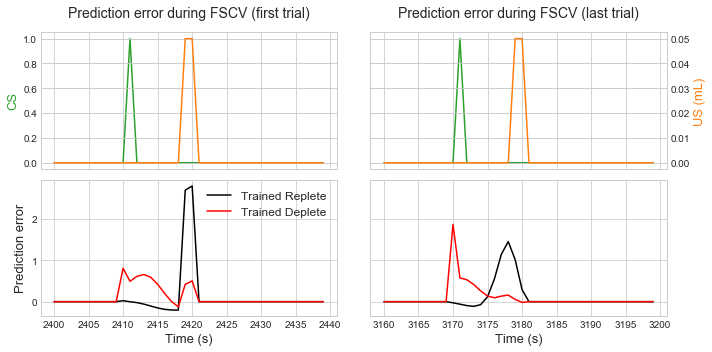

In [13]:
Epsilon2=0.1

trained_deplete2=update_TD(n_total, l, CS, US, 2, H_D, Epsilon2, H_star, 2, 1, w2D) #Trained Deplete rats
delta_deplete=trained_deplete2[2]

trained_replete2=update_TD(n_total, l, CS, US, 25, H_R, Epsilon2, H_star, 2, 1, w2R) #Trained Replete rats
delta_replete=trained_replete2[2]

#FSCV recording session
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[2400:2440], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[2400:2440], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[3160:3200], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[3160:3200], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[2400:2440], delta_replete[2400:2440], 'k-', label='Trained Replete')
ax3.plot(time[2400:2440], delta_deplete[2400:2440], 'r-', label='Trained Deplete')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[3160:3200], delta_replete[3160:3200], 'k-')
ax4.plot(time[3160:3200], delta_deplete[3160:3200], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during FSCV (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during FSCV (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

With $\epsilon = 0.1$, Trained Deplete rats have actually learnt to predict the US from the presence of the CS: at the end of the test, it is clear from the plot above that the CS triggers a dopamine response in sodium-depleted rats. In this case, a single training session that pairs a CS with an appetitive US would be sufficient for the development of a dopamine reward prediction signal, which is contrary to Cone *et al.*'s conclusions. To overcome this problem, one could assume that the rats' learning rate is much lower, as it was suggested by the previous results. However, this approach is not compatible with the results of Experiment 4, as it is shown below.   



## 4. Experiment 4: Effect of extensive experience with the predicted US on dopamine reward prediction signals

In Experiment 4, Cone *et al.* investigated whether a longer experience with the CS-US association could lead to the development of dopamine reward prediction signals. Whereas a single training session was carried out in Experiment 3, four training sessions were conducted here, coupled with four 24-h sodium depletions. Once again, rats ($n=17$) were split in two groups:

* Paired rats ($n=12$), which were always trained 24 after depletion;
* Unpaired rats ($n=5$), which were trained -2, -1, +2, or +3 days relative to depletion.

Thus, Paired rats were always trained while sodium-deplete, whereas Unpaired rats could recover between depletion and training, which dissociated sodium need from CS-US training. The training sessions were identical to Experiment 2 (4-s US delivery occurred 6 s after CS onset, 200 μL were delivered per trial, and there were 30 trials per session). Afterwards, a subset of Paired rats ($n=5$ of $12$) were depleted of sodium, as well as all Unpaired rats. Then, the FSCV recording session took place, with 20 trials presented during the session. 


### 4. 1. HRL model of Experiment 4

The model was the same as in Experiment 3, excepted for the fact that the training session was run four times, with the same trial schedule as in Experiment 2. 


### 4. 2. Results

During the FSCV recording session, Cone *et al.* found out that the CS triggered a significant phasic dopamine response in Paired rats. In Unpaired rats, a phasic dopamine response was triggered by the US only. From this, Cone *et al.* concluded that extensive experience with the appetitive features of the predicted US is essential to condition dopamine reward prediction signals (Cone *et al.* 2016, p. 3). 

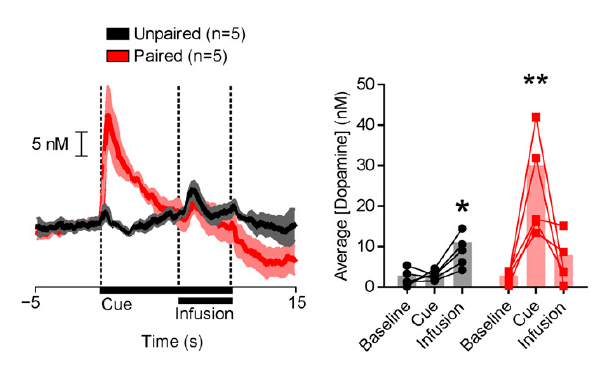

**Fig. 5 -** *Average dopamine concentration ($\pm$ SEM) across both groups.* From Cone *et al.*, p. 4.


Concerning the HRL model, for $\epsilon = 0.01$, the results are the following:

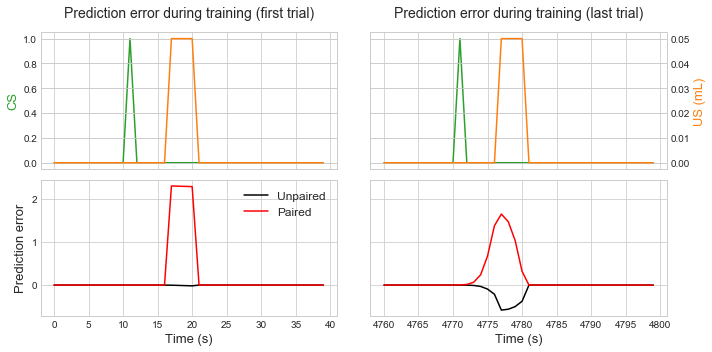

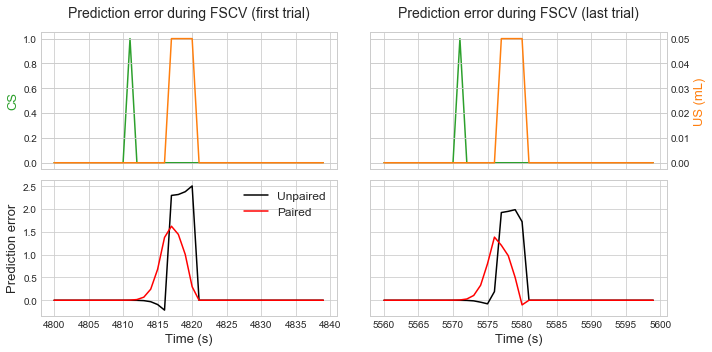

In [14]:
#create trial schedule
l=40 #length of a trial (s)
n_training=30*l #length of the training session (s)
n_test=20*l #length of the FSCV recording session (s)
n_total=4*n_training+n_test #length of whole experiment

#generate CS and US
CS=np.zeros((l))
US=np.zeros((l))

CS[11]=1
for j in range(17, 21):
    US[j]=0.05 #mL

#reset internal states at the beginning of a new session
H_P=np.zeros((n_total)) #Paired
H_U=np.zeros((n_total)) #Unpaired

for i in range(4):
    H_P[i*n_training]=2
    H_U[i*n_training]=25

H_U[4*n_training]=2 #Unpaired rats are depleted before the FSCV recording session

#initial weights
w3aP=np.zeros((l))
w3aU=np.zeros((l))    
    
time=np.arange(0, n_total, 1)

##Parameters
H_star=25
Epsilon=0.01

#Run the TD-learning algorithm on Paired and Unpaired rats
Paired=update_TD(n_total, l, CS, US, 2, H_P, Epsilon, H_star, 2, 1, w3aP) #Paired rats
Unpaired=update_TD(n_total, l, CS, US, 25, H_U, Epsilon, H_star, 2, 1, w3aU) #Unpaired rats

#prediction errors for Paired and Unpaired rats
Delta_P=Paired[2]
Delta_U=Unpaired[2]

#Plot first and last trials of the training sessions
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[:40], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[:40], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[4760:4800], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[4760:4800], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[:40], Delta_U[:40], 'k-', label='Unpaired')
ax3.plot(time[:40], Delta_P[:40], 'r-', label='Paired')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[4760:4800], Delta_U[4760:4800], 'k-')
ax4.plot(time[4760:4800], Delta_P[4760:4800], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during training (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during training (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()


#Plot first and last trials of the FSCV recording session
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[4800:4840], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[4800:4840], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[5560:5600], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[5560:5600], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[4800:4840], Delta_U[4800:4840], 'k-', label='Unpaired')
ax3.plot(time[4800:4840], Delta_P[4800:4840], 'r-', label='Paired')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[5560:5600], Delta_U[5560:5600], 'k-')
ax4.plot(time[5560:5600], Delta_P[5560:5600], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during FSCV (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during FSCV (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

From the plot above, it is clear that four training sessions are not sufficient for developing a dopamine response to the CS, even in Paired rats (although they seem to anticipate the US a bit more than Unpaired rats). However, the model fits the experimental results better when one changes the value of the learning rate $\epsilon$ (i.e., $\epsilon = 0.1$):

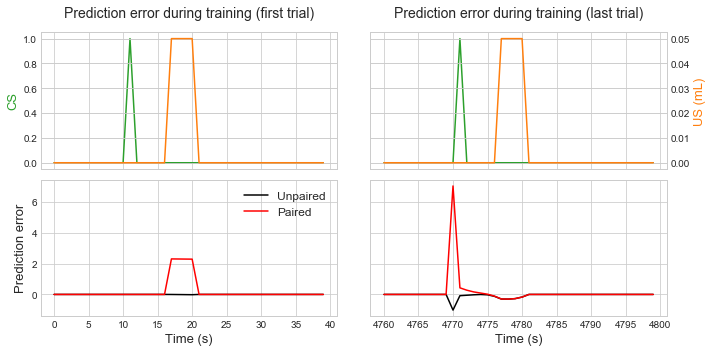

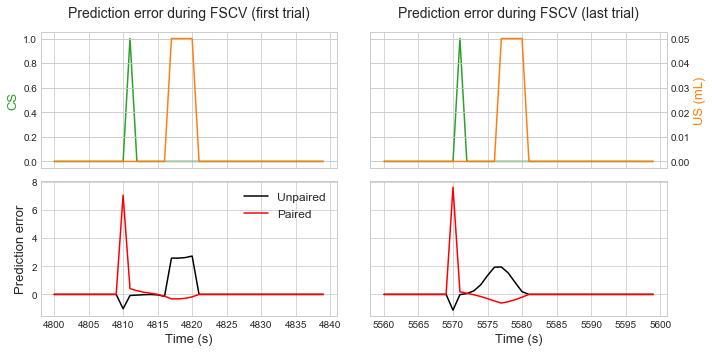

In [15]:
H_P=np.zeros((n_total)) #Paired
H_U=np.zeros((n_total)) #Unpaired

for i in range(4):
    H_P[i*n_training]=2
    H_U[i*n_training]=25

H_U[4*n_training]=2 #Unpaired rats are depleted before the FSCV recording session

#initial weights
w3aP=np.zeros((l))
w3aU=np.zeros((l))    
    
time=np.arange(0, n_total, 1)

##Parameters
H_star=25
Epsilon=0.1

#Run the TD-learning algorithm on Paired and Unpaired rats
Paired=update_TD(n_total, l, CS, US, 2, H_P, Epsilon, H_star, 2, 1, w3aP) #Paired rats
Unpaired=update_TD(n_total, l, CS, US, 25, H_U, Epsilon, H_star, 2, 1, w3aU) #Unpaired rats

#prediction errors for Paired and Unpaired rats
Delta_P=Paired[2]
Delta_U=Unpaired[2]

#Plot first and last trials of the training sessions
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[:40], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[:40], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[4760:4800], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[4760:4800], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[:40], Delta_U[:40], 'k-', label='Unpaired')
ax3.plot(time[:40], Delta_P[:40], 'r-', label='Paired')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[4760:4800], Delta_U[4760:4800], 'k-')
ax4.plot(time[4760:4800], Delta_P[4760:4800], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during training (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during training (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()


#Plot first and last trials of the FSCV recording session
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[4800:4840], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[4800:4840], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[5560:5600], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[5560:5600], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[4800:4840], Delta_U[4800:4840], 'k-', label='Unpaired')
ax3.plot(time[4800:4840], Delta_P[4800:4840], 'r-', label='Paired')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[5560:5600], Delta_U[5560:5600], 'k-')
ax4.plot(time[5560:5600], Delta_P[5560:5600], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during FSCV (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during FSCV (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

Here, Paired rats clearly learn to predict the US from the CS during the training sessions. Although Unpaired rats exhibit a small negative response to the CS (because of setpoint overshooting during training), they mainly respond to the US during the FSCV recording session. Therefore, the experimental results are better accounted for by an HRL model where $\epsilon = 0.1$. 

However, it was shown in Section 3 that the results of Experiment 3 were better accounted for by the same model, but with $\epsilon = 0.01$. Thus, there is a conflict here. As an attempt to solve it, one can propose the following hypothesis: in Experiment 3, the unability for Trained Deplete rats to predict the US is not a matter of learning rate, but rather a matter of memory consolidation. Indeed, one can suppose that a single training session is not enough for the rats to remember the weights $w$ perfectly; thus, the absence of a prediction error at the time of the CS is not the result of slow learning, but is rather due to the (total or partial) forgetting of the weights $w$. So far, memory has not been taken into account in the HRL theory. These results suggest that the HRL model could be extended, in order to include such considerations. 



## 5. Experiment 5: Effect of physiological state on the expression of dopamine reward prediction signals

In Experiment 5, Cone *et al.* explored the possibility that physiological state could affect the expression of dopamine reward prediction signals, after the latter have been acquired by training. To this end, they selected the second subset of Deplete rats from Experiment 4 ($n=7$ of $12$), which had been trained according to the 4-training-session procedure. These rats were allowed to recover, and were then tested during a 20-trial FSCV recording session, while in a replete sodium state (Paired-Replete). Afterwards, they were depleted of sodium again, and were tested during a second 20-trial FSCV recording session, while in a deplete state (Paired-Deplete). 


### 5. 1. HRL model of Experiment 5

At first, the way Experiment 5 was modeled was similar to Experiment 4: the same TD-learning algorithm was used, with $\epsilon = 0.1$. Interestingly, this was not sufficient for replicating the experimental results. Therefore, a change was made in the algorithm in order to better account for Cone *et al.*'s findings (see Section 5.2.). 


### 5. 2. Results

During the first FSCV recording session, neither the CS, nor the US, triggered any phasic dopamine response in any of the rats, which were all in the Paired-Replete condition. However, during the second FSCV recording session (rats were in the Paired-Deplete condition), the CS brought about a dopamine response, as shown on the plot below:

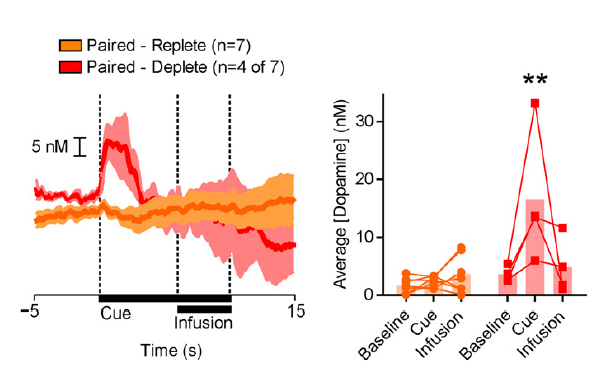

**Fig. 6 -** *Average dopamine concentration ($\pm$ SEM) across both groups.* From Cone *et al.* 2016, p. 4. 


From these results, Cone *et al.* concluded that the dopamine response to the CS is flexibly expressed based on physiological state (Cone *et al.* 2016, p. 3). 

From a modeling perspective, a replication using the TD-learning algorithm from Experiment 4 was first attempted. As shown below, it did not work:

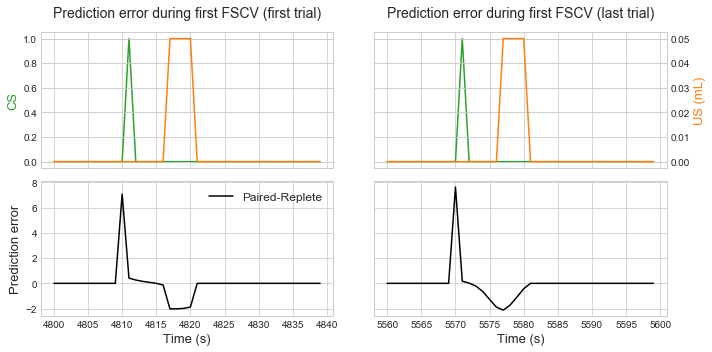

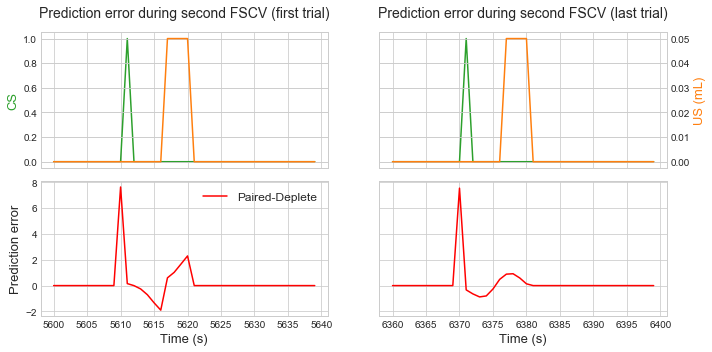

In [16]:
#create trial schedule
l=40 #length of a trial
n_training=30*l #length of training session 
n_test=40*l #length of 2 FSCV recording sessions
n_total=4*n_training+n_test #length of whole experiment

#generate CS and US
CS=np.zeros((l))
US=np.zeros((l))

CS[11]=1
for j in range(17, 21):
    US[j]=0.05

#reset internal state at the beginning of a new session
H_3b=np.zeros((n_total))

for i in range(4):
    H_3b[i*n_training]=2
    
H_3b[4*n_training]=25
H_3b[4*n_training+int(n_test/2)]=2

#initial weights
w3b=np.zeros((l))
    
time=np.arange(0, n_total, 1)


##Parameters

H_star=25
Epsilon=0.1


##Run the TD-learning algorithm

Exp3b=update_TD(n_total, l, CS, US, 2, H_3b, Epsilon, H_star, 2, 1, w3b)

#prediction error
Delta_3b=Exp3b[2]


##Plot the prediction error at different times

#first FSCV
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[4800:4840], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[4800:4840], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[5560:5600], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[5560:5600], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[4800:4840], Delta_3b[4800:4840], 'k-', label='Paired-Replete')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[5560:5600], Delta_3b[5560:5600], 'k-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during first FSCV (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during first FSCV (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

#second FSCV
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[5600: 5640], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[5600: 5640], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[6360:6400], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[6360:6400], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[5600: 5640], Delta_3b[5600: 5640], 'r-', label='Paired-Deplete')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[6360:6400], Delta_3b[6360:6400], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during second FSCV (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during second FSCV (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

From the plot above, it is clear that the CS triggers a phasic dopamine response during the whole sessions. This goes against Cone *et al.*'s results, according to which the CS does not trigger any response during the first FSCV recording session, while the rats are replete. In order to account for these results, the following proposal was made: let's suppose that a change in internal state brings about a change in weights $w$. More precisely, when the rats are allowed to recover and reach a replete state, they forget what they learnt while they were depleted of sodium: all the weights $w$ go to 0. However, when the rats are depleted of sodium again, they can access what they learnt previously during training, while they were in the same deplete condition: the weights $w$ are updated to the values they had reached at the end of the training session. A small change was made in the algorithm in order to account for this feature:

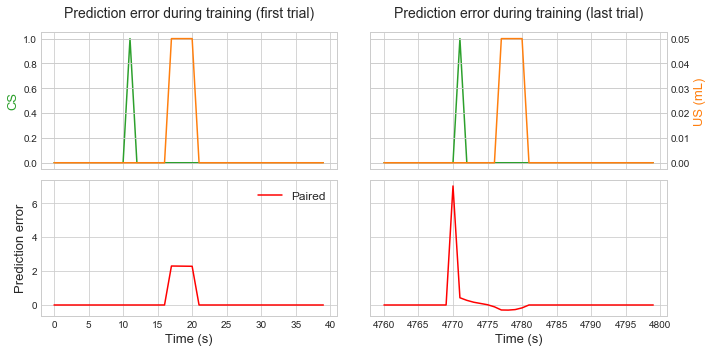

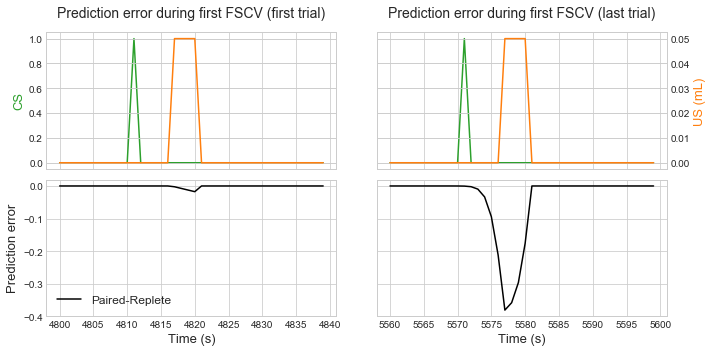

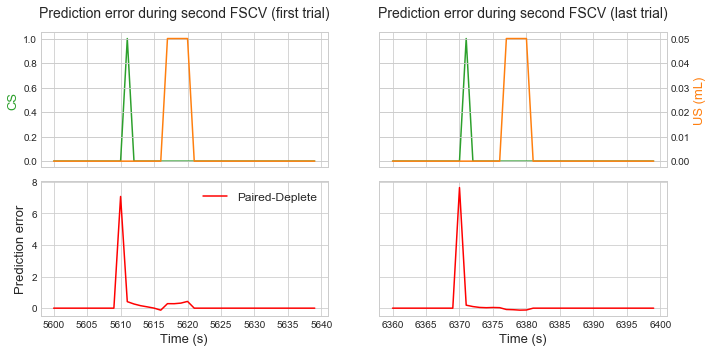

In [17]:
#create trial schedule
l=40 #length of a trial
n_training=30*l #length of training session
n_test=40*l #length of 2 FSCV recording sessions
n_total=4*n_training+n_test #length of whole experiment

#generate CS and US
CS=np.zeros((l))
US=np.zeros((l))

CS[11]=1
for j in range(17, 21):
    US[j]=0.05

#reset internal state at the beginning of a new session
H_3b=np.zeros((n_total))

for i in range(4):
    H_3b[i*n_training]=2
    
H_3b[4*n_training]=25
H_3b[4*n_training+int(n_test/2)]=2

#initial weights
w3bPR=np.zeros((l))
w3bPD=np.zeros((l))
    
time=np.arange(0, n_total, 1)


##Parameters

H_star=25
Epsilon=0.1


##Functions and Update rules

def update_TD(N, length, u, k, h0, h_init, eps, h_s, n, m, wPR, wPD):
    h=np.zeros((N)) #stores the internal states
    h[0]=h0 #initial internal state
    r=np.zeros((N)) #stores the rewards
    d=np.zeros((N)) #stores the drives
    v=np.zeros((N)) #stores the predictions
    delta=np.zeros((N)) #stores the prediction errors
    delta_v=np.zeros((N)) #stores the temporal difference
    d[0]=drive(h[0], h_s, 2, 1) #initial drive
    w=wPD #at the beginning of the training session rats are deplete
    for t in range(1, N):
        c=t%length
        u_t=u[:c+1]
        w_t=w[:c+1]
        v[t]=np.dot(w_t, u_t[::-1])
        delta_v[t-1]=v[t]-v[t-1] #temporal difference
        delta[t-1]=r[t-1]+delta_v[t-1] #TD rule
        h[t]=h[t-1]+k[c] #update internal state
        d[t]=drive(h[t], h_s, n, m) #compute drive
        r[t]=drive(h[t-1], h_s, n, m)-drive(h[t], h_s, n, m) #compute rewards according to HRL
        if h_init[t]==2: #when rats are deplete again they access weights that were learnt when deplete
            h[t]=h_init[t]
            w=wPD
        if h_init[t]==25: #when rats become replete they learn new weights
            h[t]=h_init[t]
            w=wPR
        for tau in range(c):
            w[tau]=w[tau]+eps*delta[t-1]*u[c-1-tau] #update weights according to generalized RW rule
    return v, w, delta, r, h, d, delta_v

#run the algorithm
Exp3b=update_TD(n_total, l, CS, US, 2, H_3b, Epsilon, H_star, 2, 1, w3bPR, w3bPD)

#prediction errors
Delta_3b=Exp3b[2]


##Plot the prediction error at different times

#training
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[:40], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[:40], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[4760:4800], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[4760:4800], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[:40], Delta_3b[:40], 'r-', label='Paired')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[4760:4800], Delta_3b[4760:4800], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during training (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during training (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

#first FSCV
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[4800:4840], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[4800:4840], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[5560:5600], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[5560:5600], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[4800:4840], Delta_3b[4800:4840], 'k-', label='Paired-Replete')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[5560:5600], Delta_3b[5560:5600], 'k-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during first FSCV (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during first FSCV (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

#second FSCV
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 5))
color = 'tab:green'
ax1.plot(time[5600: 5640], CS, color=color)
ax1.set_ylabel('CS', color=color, fontsize=13)
ax11 = ax1.twinx()
color='tab:orange'
ax11.plot(time[5600: 5640], US, color=color)
ax11.tick_params(axis='y', labelcolor='white')
color = 'tab:green'
ax2.plot(time[6360:6400], CS, color=color)
ax21 = ax2.twinx()
color='tab:orange'
ax21.plot(time[6360:6400], US, color=color)
ax21.set_ylabel('US (mL)', color=color, fontsize=13)
ax21.tick_params(axis='y')
ax3.plot(time[5600: 5640], Delta_3b[5600: 5640], 'r-', label='Paired-Deplete')
ax3.set_ylabel('Prediction error', fontsize=13)
ax3.set_xlabel('Time (s)', fontsize=13)
ax3.legend(fontsize=12)
ax4.plot(time[6360:6400], Delta_3b[6360:6400], 'r-')
ax4.set_xlabel('Time (s)', fontsize=13)
ax1.set_title('Prediction error during second FSCV (first trial)', fontsize=14, pad=15)
ax2.set_title('Prediction error during second FSCV (last trial)', fontsize=14, pad=15)
f.tight_layout()
plt.show()

As one can notice, this new model replicates the experimental results quite well: the CS does not trigger any response during the first FSCV recording session (Paired-Replete rats), but it does during the second session (Paired-Deplete rats). Thus, HRL theory can account for the dependency of the expression of reward prediction signals on physiological state, if a slight change concerning the weights $w$ is made. These results suggest that internal state could influence memory access, which is still to be investigated. 



## Discussion

This report shows that HRL theory is a simple and efficient framework to explain how dopamine reward prediction signals are gated by physiological state. By equating reward with drive reduction, HRL predicts most of Cone *et al.*'s results, which Reinforcement Learning or Drive Theory alone could not do. In particular, HRL predicts that the dopamine response to a stimulus depends on the latter's orosensory properties, as well as on the physiological state at the time of exposure to this stimulus; and that the acquisition of dopamine reward predictions requires that the predicted outcome first be experienced as appetitive. However, it seems that one needs supplementary assumptions in order to account fully for the facts that the development of dopamine reward prediction signals requires extensive experience with the CS-US pairing, and that the dopamine response to the CS is flexibly expressed based on physiological state. In this report, it has been suggested that these supplementary assumptions could be about memory features--in particular, memory consolidation, and the hypothesis that memory access could be gated by physiological state. These memory features could be taken into account as part of a possible extension of the HRL framework. 



## References


Cone, J. J., Fortin, S. M., McHenry, J. A., Stuber, G. D., McCutcheon, J. E., & Roitman, M. F. (2016). Physiological state gates acquisition and expression of mesolimbic reward prediction signals. *Proceedings of the National Academy of Sciences, 113*(7), 1943-1948. 

Fortin, S. M., & Roitman, M. F. (2017). Physiological state tunes mesolimbic signaling: Lessons from sodium appetite and inspiration from Randall R. Sakai. *Physiology & behavior, 178*, 21-27.

Fortin, S. M., & Roitman, M. F. (2018). Challenges to body fluid homeostasis differentially recruit phasic dopamine signaling in a taste-selective manner. *Journal of Neuroscience, 38*(31), 6841-6853.

Juechems, K., & Summerfield, C. (2019). Where does value come from?. *Trends in cognitive sciences*.

Keramati, M., & Gutkin, B. S. (2011). A reinforcement learning theory for homeostatic regulation. In *Advances in neural information processing systems* (pp. 82-90).

Keramati, M., & Gutkin, B. (2014). Homeostatic reinforcement learning for integrating reward collection and physiological stability. *Elife, 3*, e04811.

Keramati, M., Durand, A., Girardeau, P., Gutkin, B., & Ahmed, S. H. (2017). Cocaine addiction as a homeostatic reinforcement learning disorder. *Psychological review, 124*(2), 130.